# FinalCapstone_5_Analysis

This is a notebook that contains the analysis for the first part of "What is the best neighbourhood to live in as a student at Imperial College London?" (*link:* https://github.com/namiyousef/Coursera_Capstone).

**NOTE:** if you are a peer examiner from the IBM Coursera course (IBM Applied Data Science Capstone), please only mark this notebook, and the relevant parts of the report. At this current time, I will not be able to complete the second part of the project (stated in my report).

Note that the scope of this project was far greater than that required by the IBM Course, in particular with regards to the volume of data. The previous notebooks deal with different data sources and reach the conclusion that **crime** and **demographics** cannot be considered as part of the analysis, as initially stated on the project proposal.

With that in mind, this notebook contains the data exploration and cleaning, modelling and evaluation.

**Structure of the notebook:**
0. Libraries needed, configuration
1. Data attainment, cleaning and exploration
2. Data visualisation
3. Modelling
4. Evaluation
5. Final results
6. Conclusion

# 0 - Libraries needed, configuration

In [1]:
""" Libraries """

# file management and web scraping

#import os
import urllib.request
import requests
#try: 
  #  from BeautifulSoup import BeautifulSoup
#except ImportError:
 #   from bs4 import BeautifulSoup

import json

# mathematical

# data exploration
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

# visualisation
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.cm as cm
import folium
from geopy.geocoders import Nominatim # NOTE: nominatim is not great, googleV3 is much better
from geopy.geocoders import GoogleV3



# preprocessing

# modelling

# evaluation

""" Configuration """

# pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)



# matplotlib
plt.style.use('classic')

# 1. Data Attainment, Cleaning and Exploration

## Cleaning rent data

In [2]:
df_rent = pd.read_csv(('/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/Courses'
        '/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/Data/df_rent.csv'),index_col = 0)
# the data for df_rent has attained from rentbarometer in the FinalCapstone_1_ClusteringNeighbourhoods where web 
# sraping was used (using the BeautifulSoup library)

In [3]:
df_rent.head()

,Place,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,PostDist,latitude,longitude
0,Bromley,313.0,263.0,287.0,381.0,498.0,1300.0,BR1,51.519542,-0.124079
1,Croyon,197.0,280.0,355.0,654.0,803.0,1300.0,CR0,51.519542,-0.124079
2,Bethnal Green,292.0,370.0,461.0,583.0,622.0,1300.0,E2,51.519542,-0.124079
3,Bow,313.0,313.0,371.0,481.0,612.0,637.0,E3,51.519542,-0.124079
4,Canary Wharf,405.0,507.0,585.0,719.0,803.0,1300.0,E14,51.519542,-0.124079


In [10]:
# for the sake of not breaking code

df_rent_original = df_rent

df_rent = df_rent.drop(['latitude','longitude'],axis =1)

As seen above, there are many NaN values. Instead of removing these, let's replace them with either the mean or median values. For this, we need to see the distributions of prices in each column first!

6


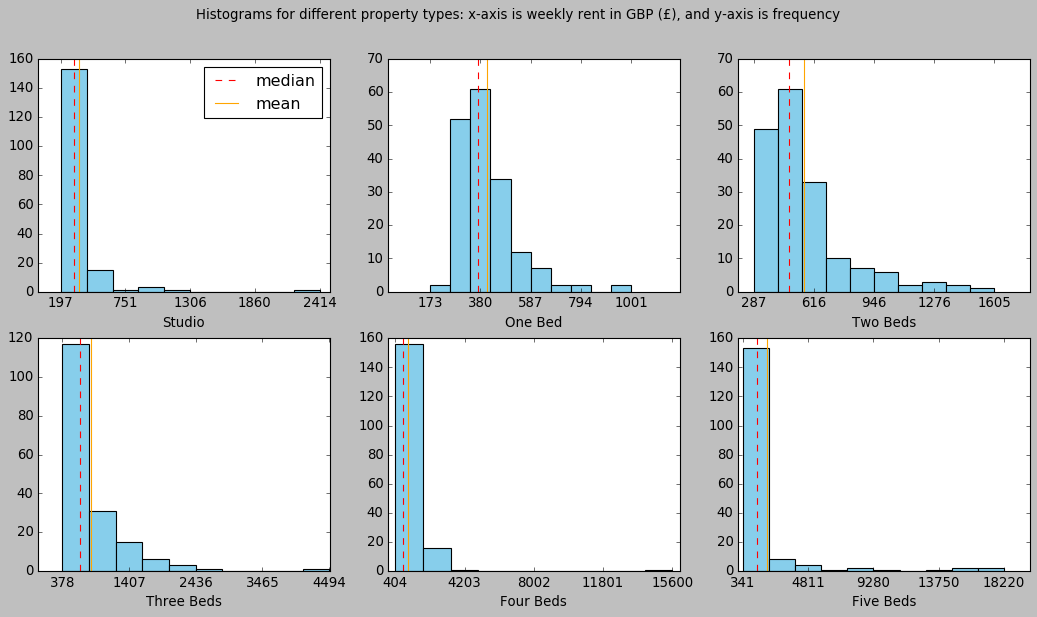

In [11]:
columns = df_rent.columns.values.tolist()[1:-1]
print(len(columns))
fig = plt.figure(figsize = (16,8))
plt.suptitle('Histograms for different property types: x-axis is weekly rent in GBP (£), and y-axis is frequency')
for index,column in enumerate(columns):
    fig.add_subplot(2,3,index+1)
    df_temp = df_rent[column]
    df_temp.dropna(axis = 0,inplace = True)
    plt.hist(df_temp,color = 'skyblue')
    plt.axvline(x = df_temp.median(),linestyle = '--',color = 'r')
    plt.axvline(x = df_temp.mean(),linestyle = '-',color = 'orange')
    plt.xticks(np.linspace(df_temp.min(),df_temp.max(),5))
    if index == 0:
        plt.legend(['median','mean'])
    plt.xlabel(column)

Seeing as for for the most part, the median seems to be more reliable... it was decidecd to replace the np.nan values with the median!

In an ideal case, one would first, as part of the preprocessing, ensure that neighbourhoods are first clustered by the average property prices (i.e. cheaper ones would be clustered together, more expensive ones in another cluster, then for each cluster, the median will be used to fill that certain cluster). This would be interesting to add for the next iteration of this project.

In [12]:
for i, column in enumerate(columns):
    df_rent[column] = df_rent[column].fillna(df_rent[column].median())

    
df_rent.head()




,Place,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,PostDist
0,Bromley,313.0,263.0,287.0,381.0,498.0,1300.0,BR1
1,Croyon,197.0,280.0,355.0,654.0,803.0,1300.0,CR0
2,Bethnal Green,292.0,370.0,461.0,583.0,622.0,1300.0,E2
3,Bow,313.0,313.0,371.0,481.0,612.0,637.0,E3
4,Canary Wharf,405.0,507.0,585.0,719.0,803.0,1300.0,E14


## Finding close supermarkets, restaurants and nightlife

In [13]:
# path to .json file containing Foursquare credentials

path = ("/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/"
        "Courses/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/config.json")

with open(path, 'r') as f:
    config = json.load(f)

# configure the foursquare API rules
CID = config['foursquare']['CID']
CSecret = config['foursquare']['CSecret']
CategoryID = '4d4b7105d754a06374d81259'
version = '20180604'
limit = 50 # maximum limit allowed by foursquare [1]
latitude = '50'
longitude = '-0.1'

# setting up a query for formatting the foursquare URL
query = {
    'CID':CID,
    'CSecret':CSecret,
    'CategoryID':CategoryID,
    'version': version,
    'limit':limit,
    'lat':latitude,
    'long':longitude
}

# categories that we are interested in searching, with their correct foursquare ID's [2]
categories = {
    'restaurants':'4d4b7105d754a06374d81259',
    'grocery': '4bf58dd8d48988d1f9941735',
    'nightlife': '4d4b7105d754a06376d81259',
    'entertainment': '4d4b7104d754a06370d81259',
    'outdoors': '4d4b7105d754a06377d81259'
}

# testing that everything works
url = ('https://api.foursquare.com/v2/venues/search?client_id={CID}'
       '&client_secret={CSecret}'
       '&categoryId={CategoryID}'
       '&ll={lat},{long}'
       '&v={version}'
       '&limit={limit}'
      )

url_test = url.format(**query)

In [67]:
#ideally, you should convert all of these into a class ! 

def plot_map(lat_long,geojson_path):
    m = folium.Map(
        location = lat_long, # must be a list
        zoom_start = 11,
        no_touch = True,
        tiles = 'CartoDB positron'
    )
    folium.GeoJson(
    geojson_path,
    name='geojson'
    ).add_to(m)
    
    return m

def add_labels(geolocator, m, address_list, address_global = ''):
    for index, address in enumerate(address_list):
        try:
            
            lat_long = get_lat_long(geolocator, address+', {}'.format(address_global))
            if lat_long != None:
                folium.Marker(
                    location = lat_long
                ).add_to(m)
        except:
            pass

        print(index/len(address_list))
    return m
    
def get_lat_long(geolocator,address):
    # note, geolocator must be defined before

    location = geolocator.geocode(address)
    return [location.latitude, location.longitude]

# note that the above, using NOMINATIM as a geocoder is terrible !

def add_labels1(geolocator, m, address_list, locality, country):
    for index, address in enumerate(address_list):


        lat_long = get_lat_long1(geolocator, address, locality, country)
        if lat_long != None:
            icon = folium.features.CustomIcon(icon_image='http://clipart-library.com/image_gallery/81095.png',
                                              icon_size=(30,30))
            folium.Marker(
                location = lat_long,
                popup = address,
                #icon=folium.Icon(color='blue',prefix='fa',icon='map-pin'),
                #icon = folium.DivIcon(html = '<div>{}</div>'.format(address))
                icon = icon
            ).add_to(m)
    return m
    
def get_lat_long1(geolocator,address,locality,country):
    # note, geolocator must be defined before

    try:
        location = geolocator.geocode(query=address, components = {'country':country,"locality":locality})
    except:
        pass
    if location != None:
        return [location.latitude, location.longitude]
    else:
        return None





In [68]:
#geolocator = Nominatim(user_agent="foursquare_agent") DONT USE! NOMINATIM DOES NOT WORK WELL....

# london geodata {from source:[3]}
path = ("/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/"
        "Courses/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/Data/london_geodata.json")

geolocator = GoogleV3(config['google']['key'])

lat_long = get_lat_long(geolocator, 'London, United Kingdom')
m = plot_map(lat_long, path)
#m = add_labels(geolocator, m, df_rent.PostDist.unique().tolist(), address_global = 'London, England, United Kingdom')
m = add_labels1(geolocator, m, df_rent.PostDist.unique().tolist(), 'London','United Kingdom')


# add imperial college
lat_long = get_lat_long(geolocator, 'Imperial College London')
folium.Marker(
    location = lat_long,
    icon=folium.Icon(color = 'lightgray',icon_color='#002147',prefix='fa',icon='university'),
    popup= 'Imperial College London'
).add_to(m)
m

Note that some of the postcodes in our dataset are actually outside what would be considered 'London' (and thus maybe as part of greater London). The data set also does not cover some major locations, as shown by the map. Unfortunately, there isn't much in our power to improve this!

That said though, I will continue the project for now (as this is the 'first' iteration). Future improvements should look into scraping data from websites such as 'rightmove.com'.

In [69]:
""" ONLY RUN THIS CELL WHEN NECESSARY TO CONSERVE API CALLS! """

url = ('https://api.foursquare.com/v2/venues/search?client_id={CID}'
       '&client_secret={CSecret}'
       '&categoryId={CategoryID}'
       '&ll={lat},{long}'
       '&v={version}'
       '&limit={limit}'
      )

query = {
    'CID':CID,
    'CSecret':CSecret,
    'CategoryID':CategoryID,
    'version': version,
    'limit':limit,
    'lat':latitude,
    'long':longitude
}

geolocator = GoogleV3(config['google']['key'])

all_venues = dict.fromkeys(
    df_rent.PostDist.unique().tolist()
)


for postal_district in df_rent.PostDist.unique():
    location = geolocator.geocode(query=postal_district, components = {'country':'United Kingdom',
                                                                       "locality":'London'})
    
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        query['lat'] = latitude
        query['long'] = longitude
        all_venues[postal_district] = dict.fromkeys(
            categories.keys()    
        )
        for category, item in categories.items():
        
            query['CategoryID'] = item
            url_temp = url.format(**query)
            results = requests.get(url_temp).json()
            dict_temp = {category: results}
            all_venues[postal_district].update(dict_temp)
        #results = requests.get(url_temp).json()
        #df_temp = json_normalize(results)
        #dict_temp = {postal_district: df_temp}
        #all_venues.update(dict_temp)

In [107]:
# save the json file
saving = json.dumps(all_venues)
open("all_venues.json","w").write(saving)

# we are only interested, really, in the distance from our postal district, as well as the type of venue that it is
# although even this may not be necesary. Either way, we can do the following:
# note that there are errors in some, for example under SW1 you can find items from W1, since they are very close to 
# each other. That said we'll be creating a scoring metric, so this would not be an issue!

post_codes = []
type_major = []
type_minor = []
distance = []
names = []

for postal_district in df_rent.PostDist.unique():
    for category, item in categories.items():
        if all_venues[postal_district] != None:
            venues = all_venues[postal_district][category]['response']['venues']
            for venue in venues:
                distance.append(venue['location']['distance'])
                type_minor.append(venue['categories'][0]['name'])
                type_major.append(category)
                post_codes.append(postal_district)
                names.append(venue['name'])
                pass
    
print(all_venues['BR1']['restaurants']['response']['venues'][0]['categories'][0])
        
df_venues = pd.DataFrame(data={'postcodes':post_codes,
                               'names':names,
                               'distance':distance,
                               'type_major':type_major,
                               'type_minor':type_minor})

path = '../Data/{}'
df_venues.to_csv(path.format('df_venues.csv'))

df_venues.head()



{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}


,postcodes,names,distance,type_major,type_minor
0,BR1,EL&N,16270,restaurants,Café
1,BR1,L'ETO Caffè,16458,restaurants,Café
2,BR1,EL&N,16179,restaurants,Café
3,BR1,The Coffee Bar,16272,restaurants,Coffee Shop
4,BR1,North Audley Cantine (NAC),16655,restaurants,French Restaurant


## Finding closeness to university using Google Maps API

In [110]:
# configure the Google Directions API rules

key = config['google']['key']

origin = 'SW7+3BQ+London+England' # where you start from (this would be the postcode district!)

destination = 'Imperial College London London United Kingdom'
destination = destination.replace(' ','+') # where you want to end up, note '+' added for Google API requirements

mode = 'bicycling' # can also be 'walking' or 'transit'

transit_mode = 'bus' # can also be 'subway'

# setting up a query for formatting the foursquare URL
query = {
    'key':key,
    'origin':origin,
    'destination': destination,
    'mode': mode
}

# testing that everything works
url = ('https://maps.googleapis.com/maps/api/directions/json?key={key}'
       '&origin={origin}'
       '&destination={destination}'
       '&mode={mode}'
      )

# if mode == transit, then: url +  '&transit_mode={transit_mode}'

url_test = url.format(**query)


modes = {
    'walking':'walking', 
    'bicycling':'bicycling',
    'transit': ['bus','subway']
}


In [111]:
all_directions = dict.fromkeys(
    df_rent.PostDist.unique().tolist()
)

for postal_district in df_rent.PostDist.unique():
    
    all_directions[postal_district] = dict.fromkeys(
        list(modes.values())[:-1] + modes['transit']
    )
    query['origin'] = '{}+London+United+Kingdom'.format(postal_district)
    for mode, item in modes.items():
        query['mode'] = mode

        if mode == 'transit':
            for transit_type in item:
                url_temp = url.format(**query) + '&transit_mode={}'.format(transit_type)
                results = requests.get(url_temp).json()
                dict_temp = {transit_type: results}
                all_directions[postal_district].update(dict_temp)
        else:
            url_temp = url.format(**query)   
            results = requests.get(url_temp).json()
            dict_temp = {mode: results}
            all_directions[postal_district].update(dict_temp)

In [113]:
# collect postcodes
post_dists_latlong = {}
geolocator = GoogleV3(config['google']['key'])
for postal_district in df_rent.PostDist.unique():
    
    try:
        location = geolocator.geocode(query=postal_district, components = {'country':'United Kingdom',
                                                                           "locality":'London'})
    except:
        pass
    if location != None:
        post_dists_latlong[postal_district] = [location.latitude,location.longitude]
    else:
        print(postal_district)


EC3


In [114]:
# retrieve important information 
# let's try multi index pandas tables !
post_dists = []
trans_mode = []
duration = []
lats = []
longs = []
for post_dist in df_rent.PostDist.unique():
    for item in list(modes.values())[:-1] + modes['transit']:
        post_dists.append(post_dist)
        trans_mode.append(item)
        duration.append(all_directions[post_dist][item]['routes'][0]['legs'][0]['duration']['value'])
        


        
index_tuples = list(zip(post_dists, trans_mode))
index = pd.MultiIndex.from_tuples(index_tuples, names=['PostDist', 'TransportMode'])
df_travel = pd.DataFrame(data={'duration':duration},index = index)

df_travel.head()

duration
PostDist TransportMode          
BR1      walking           14921
         bicycling          4474
         bus                4368
         subway             4033
CR0      walking           11946

In [115]:
df_travel.to_csv("../Data/df_travel.csv")

In [408]:
lats = []
longs = []
for post_dist in df_rent.PostDist.values:
    lats.append(post_dists_latlong[post_dist][0])
    longs.append(post_dists_latlong[post_dist][1])

print(lats)
df_rent['latitude'] = lats
df_rent['longitude'] = longs


df_rent.to_csv(("/Users/yousefnami/Desktop/Yousef/PrivateTings/MyStuff/"
                  "Courses/IBMDataScienceCertificate/CapstoneProject/Capstone/Coursera_Capstone/Data/df_rent.csv"))

KeyError: 'EC3'

# 2. Data visualisation

In [405]:
df_final = df_rent
places = []
for PostDist in df_final.PostDist.unique():
    df_temp = df_final[df_final.PostDist == PostDist]
        
    names = [item for item in df_temp.Place.values]
    places.append(names)
        

df_final = df_final.groupby('PostDist').mean()
print(len(places))
df_final['Place'] = places

df_final.head()


106


,Studio,One Bed,Two Beds,Three Beds,Four Beds,Five Beds,latitude,longitude,Place
PostDist,,,,,,,,,
BR1,313.000000,263.000000,287.000000,381.000000,498.000000,1300.0,51.519542,-0.124079,[Bromley]
CR0,197.000000,280.000000,355.000000,654.000000,803.000000,1300.0,51.519542,-0.124079,[Croyon]
E1,327.000000,408.666667,513.666667,797.333333,500.666667,1300.0,51.519542,-0.124079,[Bethnal Green]
E11,313.000000,173.000000,477.500000,595.000000,803.000000,1300.0,51.519542,-0.124079,[Bow]
E14,342.333333,383.666667,483.000000,593.666667,717.666667,1300.0,51.519542,-0.124079,"[Canary Wharf, Isle of Dogs, Mudchute]"


In [406]:
imperial_latitude = 51.498356
imperial_longitude = -0.176894

import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

distance_from_uni = [
    distance(
        [imperial_latitude, imperial_longitude],
        lat_long
    )
    
    for lat_long in df_final[['latitude','longitude']].values.tolist()
    
]

distance_from_uni

[4.348560534087966,
 4.348560534087966,
 4.348560534087539,
 4.348560534087966,
 4.348560534087539,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087539,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534088393,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087539,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534088394,
 4.348560534087966,
 4.348560534087539,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,
 4.348560534087539,
 4.348560534087966,
 4.348560534087966,
 4.348560534087966,


# Conclusion

# References

1. https://stackoverflow.com/questions/45992235/foursquare-api-get-filtered-list-of-restaurants
2. https://developer.foursquare.com/docs/build-with-foursquare/categories/
3. https://github.com/sjwhitworth/london_geojson/blob/master/london_postcodes.json


